# Setup

In [ ]:
import numpy as np
import pylab as plt
from ipywidgets import interact

ground_truth = lambda x: x * np.sin(x*2)
def get_data(ground_truth, n_samples, noise=0.5):
    X = np.random.uniform(0, 6, n_samples)
    y = ground_truth(X) + np.random.randn(*X.shape)*noise
    return X, y

# Gaussian Processes

In this exercise, we will implement a Gaussian process for regession.

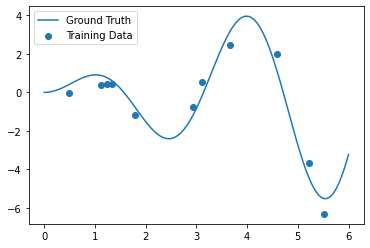

In [ ]:
np.random.seed(5)
X, y = get_data(ground_truth, n_samples=11)
axis = np.linspace(0, 6, 101)

plt.plot(axis, ground_truth(axis), label='Ground Truth')
plt.scatter(X, y, label='Training Data')
plt.legend()
plt.show()

## Kernel functions
Implement the kernel functions which are defined below.

> Exponential Covariance (Equation 6.63): $$k(\mathbf{x}_n, \mathbf{x}_m)  = \theta_0 \exp\left( - \frac{\theta_1}{2} \Vert \mathbf{x}_n - \mathbf{x}_m \Vert^2 \right) + \theta_2 + \theta_3 \mathbf{x}_n^T\mathbf{x}_m.$$
> Exponential Kernel (Equation 6.56): $$k\left(x, x^{\prime}\right)=\exp \left(-\theta\left|x-x^{\prime}\right|\right)$$

In [ ]:
class ExponentialCovariance:
    """Gaussian kernel from Eq. 6.63."""
    def __init__(self, theta0=1, theta1=1, theta2=0, theta3=0):
        self.theta0 = theta0
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3

    def __call__(self, x, y):
        x, y = np.array(x), np.array(y)
        return self.theta0 * np.exp(- (self.theta1/2) * np.sum((x-y)**2) + self.theta2 + self.theta3*np.dot(x, y))

kernel = ExponentialCovariance()
kernel(2, 1) # should return 0.6065306597126334

0.6065306597126334

In [ ]:
class ExponentialKernel:
    """Exponential kernel from Eq. 6.56."""
    def __init__(self, theta=1):
        self.theta = theta

    def __call__(self, x, y):
        return np.exp(- self.theta * np.abs(x - y))
kernel = ExponentialKernel()
kernel(2, 1) # should return 0.36787944117144233

0.36787944117144233

In [ ]:
@interact(theta=(-3, 3, 0.1))
def plot(theta=1):
    point = 0
    axis = np.linspace(-3, 3, 201)

    kernel = ExponentialCovariance()
    plt.plot(axis, [kernel(0, x) for x in axis])

    kernel = ExponentialKernel(theta)
    plt.plot(axis, [kernel(0, x) for x in axis])

interactive(children=(FloatSlider(value=1.0, description='theta', max=3.0, min=-3.0), Output()), _dom_classes=…

        Feel free to implement additional kernels from the lecture. They can be used in the resulting GP model.

## Prior Distribution

> Implment the class `GaussianProcess` with the following methods:
> - `__init__`: Initializes all hyperparameters of our model. In this case we need the corresponding kernel function we want to use.
> - `prior_samples`: Provides random samples from the prior distribution over functions.


In [ ]:
class GaussianProcess:
    def __init__(self, kernel_func):
        self.kernel_func = kernel_func

    def prior_samples(self, X, n_samples):
        mu = np.zeros_like(X)
        cov = np.array([[self.kernel_func(x, y) for x in X] for y in X])
        prior_samples = np.random.multivariate_normal(mu, cov, size=n_samples)
        return prior_samples

> Plot samples according to the figure on slide 47.

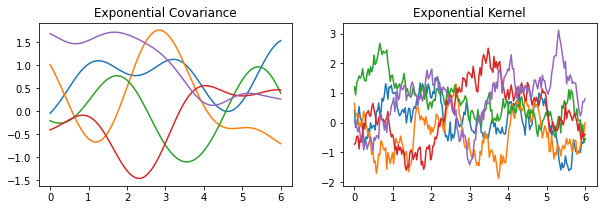

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.title('Exponential Covariance')
kernel_func = ExponentialCovariance()
gp = GaussianProcess(kernel_func)
axis = np.linspace(0, 6, 201)
plt.plot(axis, gp.prior_samples(axis, 5).T)

plt.subplot(122)
plt.title('Exponential Kernel')
kernel_func = ExponentialKernel()
gp = GaussianProcess(kernel_func)
axis = np.linspace(0, 6, 201)
plt.plot(axis, gp.prior_samples(axis, 5).T)

plt.show()

## Conditional distribution

Our ultimate goal is to find the predictive distribution. That is, we seek to evaluate  $p(t_{N+1}| \mathbf{t})$ for a new sample $\mathbf{x}_{N+1}$.
In order to find the conditional distribution $p(t_{N+1}| \mathbf{t})$:
1. We start by writing down the joint distribution $p(\mathbf{t}_{N+1})$, where $\mathbf{t}_{N+1}$ denotes the vector $(t_1,\ldots,t_N, t_{N+1})^T$.
2. We then apply the results from Section 2.3.1 to obtain the required conditional distribution.

### Joint Distribution
The joint distribution over $t_1, \ldots, t_{N+1}$ will be given by $$\quad p(\mathbf{t}_{N+1}) = \mathcal{N}(\mathbf{t}_{N+1}| \mathbf{0}, \mathbf{C}_{n+1})$$
where $\mathbf{C}_{N+1}$ is an $(N+1)\times(N+1)$ covariance matrix with elements given by $$\quad C\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)=k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)+\beta^{-1} \delta_{n m}$$
Because the joint distribution is Gaussian, we can apply the results from Section 2.3.1 to find the conditional Gaussian distribution. To do this, we partition the covariance matrix as follows
$$\quad \textbf{C}_{N+1} =  \left( \begin{array}{cc} \textbf{C}_{N} & \textbf{k}  \\ \textbf{k}^{T} & c  \\ \end{array} \right)$$ where $\mathbf{C}_N$ is the $N \times N$ covariance matrix, the vector $\mathbf{k}$ has elements $k(\mathbf{x}_n, \mathbf{x}_{N+1})$ for $n = 1,\ldots,N$, and the scalar $c = k(\mathbf{x}_{N+1}, \mathbf{x}_{N+1}) + \beta^{-1}$. We see that the conditional distribution $p(t_{N+1}|\mathbf{t})$ is a Gaussian distribution with mean and covariance given by
$$\quad m(\mathbf{x}_{N+1}) = \mathbf{k}^T \mathbf{C}_N^{-1}\mathbf{t} \quad \quad \sigma^2 (\mathbf{x}_{N+1}) =  c - \mathbf{k}^T\mathbf{C}_n^{-1}\mathbf{k}$$

The only restriction on the kernel function is that the covariance matrix must be positive definite. If $\lambda_i$ is an eigenvalue of $\mathbf{K}$, then the corresponding eigenvalue of $\mathbf{C}$ will be $\lambda_i + \beta^{-1}$.
It is therefore sufficient that the kernel matrrix $k(\mathbf{x}_n, \mathbf{x}_m)$ be positive semidefinite for any pair of points $\mathbf{x}_n$ and $\mathbf{x}_m$, so that $\lambda_i \geq 0$, because any eigenvalue $\lambda_i$ that is zero will still give rise to a positive eigenvalue for $\mathbf{C}$ because $\beta \ge 0$.

Note that the mean (6.66) of the predictive distribution can be written, as a function of $\mathbf{x}_{N+1}$, in the form  $$\quad m(\mathbf{x}_{N+1}) = \sum_{n=1}^{N} a_n k(\mathbf{x}_n \mathbf{x}_{N+1})$$ where $a_n$ is the $\text{n}^{\text{th}}$ component of $\mathbf{C}_N^{-1}\mathbf{t}$. Thus, if the kernel $k(\mathbf{x}_n, \mathbf{x}_m)$ depends only on the distance $\Vert \mathbf{x}_n - \mathbf{x}_m \Vert$, then we obtain an expansion on radial basis functions.
The results (6.66) and (6.67) define the predictive distribution for Gaussian process regression with an arbitrary kernel function $k(\mathbf{x}_n, \mathbf{x}_m)$.
> Implement the predict function based on Eq. 6.68 and extend this idea for the confidence sigma. Don't forget to extend previous functions to include the noise.

In [ ]:
class GaussianProcess(GaussianProcess):
    def fit(self, X, y, noise=.1):
        self.X = X
        self.y = y
        self.noise = noise
        self.cov_mat = np.array([[self.kernel_func(x, y) for x in self.X] for y in self.X]) + self.noise*np.eye(len(self.X))
        self.cov_mat_inv = np.linalg.pinv(self.cov_mat)

    def predict_conditional(self, inp):
        k = np.array([self.kernel_func(inp, x) for x in self.X])
        c = self.kernel_func(inp, inp) + self.noise

        mean = k @ self.cov_mat_inv @ self.y
        var = c - k @ self.cov_mat_inv @ k
        return mean, var

> Plot the predictions of the Gaussian Process with the corresponding dataset. Plot the standard deviation as done [here](https://stackoverflow.com/questions/45136420/filling-range-of-graph-in-matplotlib).

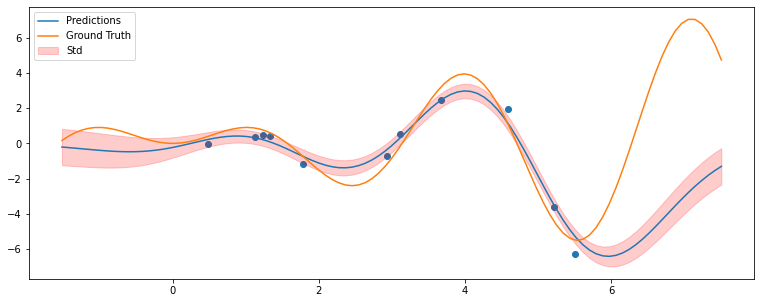

In [ ]:
fig = plt.figure(figsize=(13, 5))
axis = np.linspace(min(X)-2, max(X)+2, 101)

gp = GaussianProcess(ExponentialCovariance(1))
gp.fit(X, y, noise=0.1)
preds = np.array([gp.predict_conditional(x) for x in axis])

mean = preds[:, 0]
std = np.sqrt(preds[:, 1])

plt.plot(axis, mean, label='Predictions')
plt.plot(axis, ground_truth(axis), label='Ground Truth')
plt.scatter(X, y)
plt.fill_between(axis, mean-std, mean+std, color='red', alpha=.2, label='Std')
plt.legend()
plt.show()

> Test your code with the following interactive plot and modify the parameters to be get an intuitive understanding for the behavior of the kernel.
> You might have to adapt the code if it is not working out of the box with your own implementation.

In [ ]:
def plot_predict_conditional(noise=.2, theta0=1, theta1=1, theta2=0, theta3=0):
    kernel_func = ExponentialCovariance(theta0=theta0, theta1=theta1, theta2=theta2, theta3=theta3)
    gp = GaussianProcess(kernel_func)
    gp.fit(X, y, noise=noise)

    fig = plt.figure(figsize=(13, 5))
    axis = np.linspace(min(X)-2, max(X)+2, 101)

    preds = np.array([gp.predict_conditional(x) for x in axis])

    mean = preds[:, 0]
    std = np.sqrt(preds[:, 1])

    plt.plot(axis, mean, label='Predictions')
    plt.plot(axis, ground_truth(axis), label='Ground Truth')
    plt.scatter(X, y)
    plt.fill_between(axis, mean-std, mean+std, color='red', alpha=.2, label='Std')
    plt.legend(loc=2)
    plt.show()

interact(plot_predict_conditional,  noise=(0.01, 1, 1e-3), theta0=(0, 5, .1), theta1=(0, 5, .1), theta2=(0, 5, .1), theta3=(0, 5, .1))

interactive(children=(FloatSlider(value=0.2, description='noise', max=1.0, min=0.01, step=0.001), FloatSlider(…

<function __main__.plot_predict_conditional>